In [1]:
import matplotlib.pyplot as plt

import numpy as np
import numba
from sklearn.cluster import KMeans

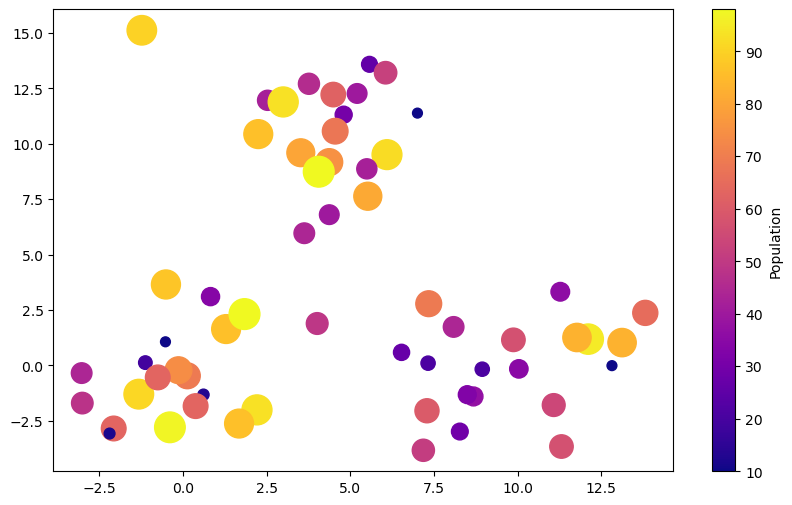

In [2]:
centers = np.array([[0, 0], [10, 0], [5, 10]])

# Générer les points à l'intérieur de chaque cluster
points_per_cluster = 20
points = []

for center in centers:
    # Générer des points aléatoires autour du centre du cluster
    cluster_points = np.random.normal(loc=center, scale=2, size=(points_per_cluster, 2))
    points.extend(cluster_points)

points = np.array(points)
xp = points[:, 0]
yp = points[:, 1]


population = np.random.randint(10, 101, size = 3*20)
size = population*5
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')

In [26]:
Hs = 1
N = 18
n_clusters = 3

Imin = 0.1

In [27]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [28]:

@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    somme = 0
    for i in range(N) : 
        somme += x[2*N+i]
    return somme
  

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += x[2*N+i]/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


def f_sol(x):
    result = np.zeros(len(population))
    for i in range(len(population)) : 
        somme = 0
        for j in numba.prange(N) : 
            
            dij_sq = pyth(xp[i], x[2*j], yp[i], x[2*j+1]) + Hs**2
            somme += x[2*N+j]/(dij_sq) 
        result[i] = somme/population[i]
    return result

def contrainte_intensity(x) : 
    return x[2*N:]

def contrainte_position_x(x) : 
    x_pos = np.zeros(N)
    for i in range(N) : 
        x_pos[i] = x[2*i]
    return x_pos

def contrainte_position_y(x) : 
    y_pos = np.zeros(N)
    for i in range(N) :
        y_pos[i] = x[2*i+1]
    return y_pos



In [29]:
P = np.vstack((xp, yp)).T

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

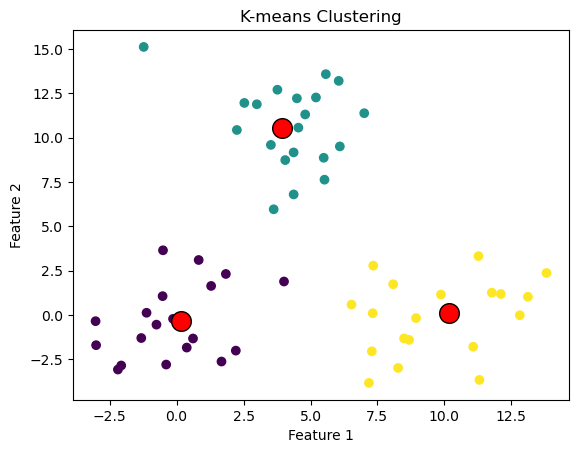

In [30]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [35]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))
x0_intensity = np.ones(N)*15
x0 = np.hstack((x0, x0_intensity))



        
        
myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
myc4 = NonlinearConstraint(contrainte_intensity, 0, 20)
contraintes = [myc1, myc4]




t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", contrainte_intensity(resultat.x))

temps :  0.23796296119689941
 message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
 success: False
  status: 4
     fun: 88.6873646206432
       x: [-6.903e-01 -1.298e+00 ...  5.646e+00  5.813e+00]
    nfev: 1000
   maxcv: 0.22914173327359666
Résultat de l'optimisation: 88.6873646206432
Valeurs optimales des variables: [-0.69030961 -1.29816292  4.45020617 11.83195487 12.18391893  1.22280219
 -1.73356495 -1.34162916  5.27620018  7.69061939  9.74934566  1.22544239
 -1.42418079 -1.35187826  3.22175637 11.16086567  8.33018146 -1.0046264
 -0.18828006 -1.25438958  3.27369964 11.03487542 10.89636056  1.27207603
 -0.96761089 -1.15494837  4.179703    8.69492562 13.20924325  1.86733084
 -0.398486   -0.74165497  3.00149156 10.51791676 12.91413898  1.60350545
  3.6127954   6.21460917  6.36363295  3.17767878  7.5678053   2.7201872
  3.55252657  5.544568    4.69088318  3.52644871  6.51443145  3.65320475
  4.8195544   6.50314684  5.77171583  2.99

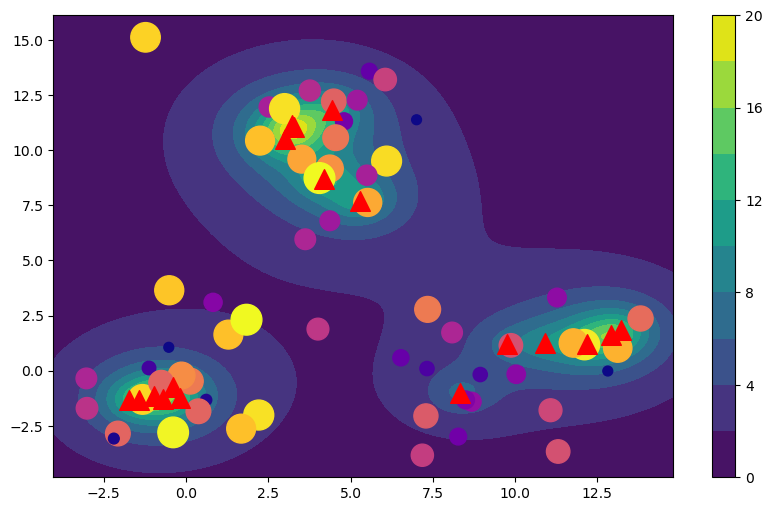

In [36]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += sol[2*N+i]/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")


Comme on peut le voir, il arrive pas à respecter la contrainte, alors que pourtant avant avec 18 satellites, on pouvait avoir la contrainte de satisfaite. 
Mon idée est donc la suivante : on va enfait résoudre d'abord le problème sans chercher à minimiser la somme totale des intensités, puis on va essayer de minimiser la somme des intensités à partir des conditions initiales qui seront enfait notre solution.